In [100]:
import numpy as np
from scipy.linalg import orth
import matplotlib.pyplot as plt
import random
%matplotlib inline 
from __future__ import division
from sklearn import preprocessing
plt.rcParams['figure.figsize'] = (15.0, 10.0)

In [101]:
def my_ppca(Ye, d):
    N, D = Ye.shape
    eps   = 1e-4;  
    hidden = np.isnan(Ye)
    missing = np.sum(hidden)
    
    mean = np.nanmean(Ye, axis=0)
    std = np.nanstd(Ye, axis=0)
    Ye = (Ye-mean)/std
   
    Ye[hidden] = 0
                
    C = np.random.randn(D, d)
    CtC = np.dot(C.T, C)
    X = np.dot(np.dot(Ye, C), np.linalg.inv(CtC))
    recon = np.dot(X, C.T)
    recon[hidden] = 0
    ss = np.sum((recon - Ye)**2)/(N*D - missing)
    
    count = 1
    old = np.inf
    
    while True:

            Sx = np.linalg.inv(np.eye(d) + CtC/ss)
            ss_old = ss
            if missing:
                proj = np.dot(X, C.T)
                Ye[hidden] = proj[hidden]
            X = np.dot(np.dot(Ye, C), (Sx/ss))  #e step

            SumXtX = np.dot(X.T, X)
            C = np.dot(np.dot(Ye.T, X), np.linalg.pinv(SumXtX + N*Sx))
            CtC = np.dot(C.T, C)
            ss = (np.sum((np.dot(X, C.T)-Ye)**2) + N*np.sum(CtC*Sx) + missing*ss_old)/(N*D)

            objective = N*D + N*(D*np.log(ss)+np.trace(Sx)-np.log(np.linalg.det(Sx))) \
                       +np.trace(SumXtX)-missing*np.log(ss_old);           
           
            rel_ch    = abs( 1 - objective / old );
            old       = objective;
            
            count += 1
    
            print "Objective: %.2f relative change: %.5f " % (objective, rel_ch)
        
            if ( rel_ch < eps) and (count > 5):
                break
    
    C = orth(C)
    vals, vecs = np.linalg.eig(np.cov(np.dot(Ye, C).T))
    order = np.flipud(np.argsort(vals))
    
    print order
    print vecs
    vals = vals[order]
    vecs = vecs[:, order]
    
    C = np.dot(C, vecs)
    X = np.dot(Ye, C)
    
    return X

In [104]:
f = open("virus2.dat")
line_list = f.read().split("\n")
line_list.pop()

x_list = np.array([ map(int, l.split(" ")) for l in line_list])

Objective: 826.39 relative change: 1.00000 
Objective: 588.70 relative change: 0.28763 
Objective: 523.82 relative change: 0.11020 
Objective: 510.50 relative change: 0.02543 
Objective: 506.44 relative change: 0.00795 
Objective: 504.09 relative change: 0.00465 
Objective: 502.32 relative change: 0.00350 
Objective: 500.93 relative change: 0.00277 
Objective: 499.84 relative change: 0.00218 
Objective: 498.99 relative change: 0.00170 
Objective: 498.34 relative change: 0.00130 
Objective: 497.86 relative change: 0.00098 
Objective: 497.50 relative change: 0.00072 
Objective: 497.23 relative change: 0.00053 
Objective: 497.04 relative change: 0.00038 
Objective: 496.91 relative change: 0.00027 
Objective: 496.81 relative change: 0.00019 
Objective: 496.74 relative change: 0.00014 
Objective: 496.70 relative change: 0.00010 
[0 1]
[[ 0.99989185 -0.01470682]
 [ 0.01470682  0.99989185]]
Objective: 863.48 relative change: 1.00000 
Objective: 709.24 relative change: 0.17863 
Objective: 634.

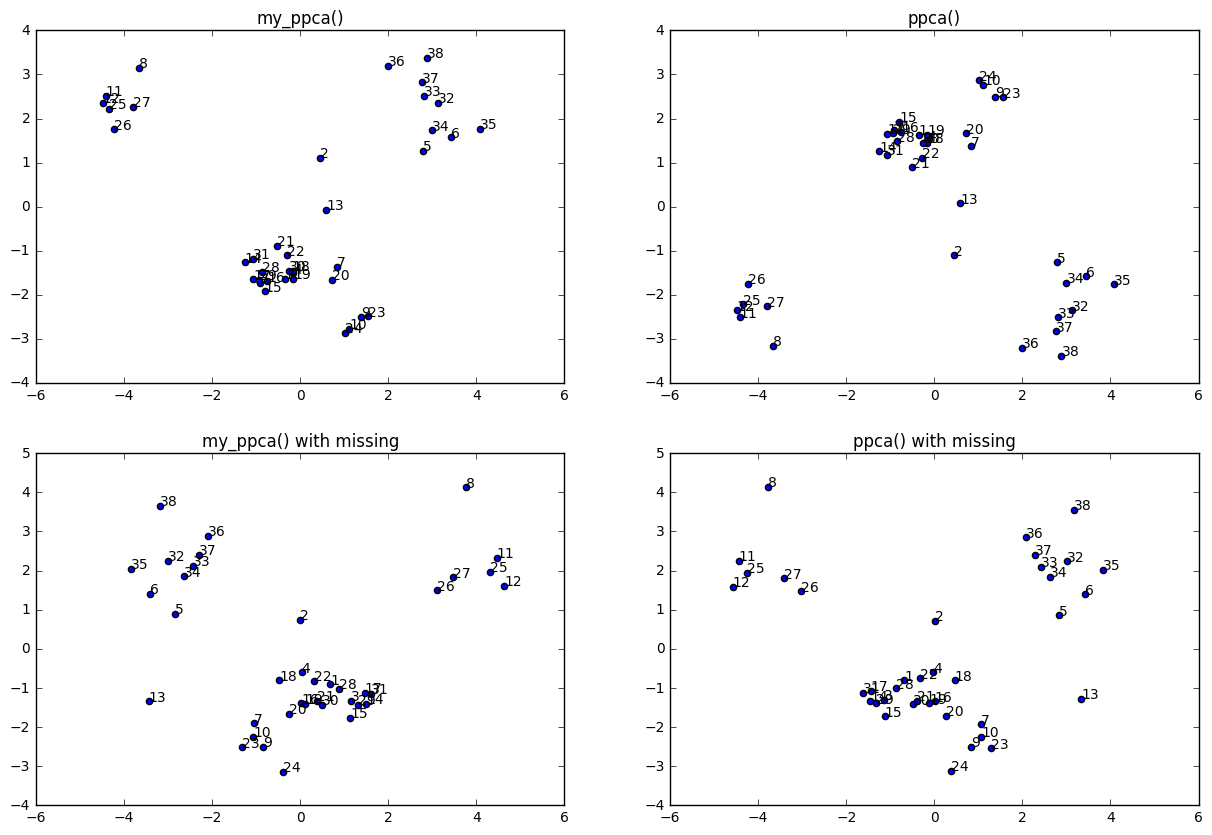

In [105]:
X1 = my_ppca(x_list, 2)
fig = plt.figure()
ax1 = fig.add_subplot(221)
x = X1[:,0]
y = X1[:,1]
ax1.scatter(x,y)
ax1.set_title("my_ppca()")
for i, txt in enumerate(range(1,39)):
    ax1.annotate(txt, (x[i],y[i]))
    
ax2 = fig.add_subplot(222)
from ppca import PPCA
ppca = PPCA(x_list)
ppca.fit(d=2)
x = ppca.X[:,0]
y = ppca.X[:,1]
ax2.scatter(x,y)
ax2.set_title("ppca()")
for i, txt in enumerate(range(1,39)):
    ax2.annotate(txt, (x[i],y[i]))
    
#with_missing
x_list = x_list.astype(float)
choose = np.random.choice([False,True], x_list.shape, p = [0.8, 0.2])
for x,ch in zip(x_list,choose):
    x[ch] = np.nan
    
ax3 = fig.add_subplot(223)
X1 = my_ppca(x_list, 2)
x = X1[:,0]
y = X1[:,1]
ax3.scatter(x,y)
ax3.set_title("my_ppca() with missing")
for i, txt in enumerate(range(1,39)):
    ax3.annotate(txt, (x[i],y[i]))
    
ax4 = fig.add_subplot(224)
ppca = PPCA(x_list)
ppca.fit(d=2)
x = ppca.X[:,0]
y = ppca.X[:,1]
ax4.scatter(x,y)
ax4.set_title("ppca() with missing")
for i, txt in enumerate(range(1,39)):
    ax4.annotate(txt, (x[i],y[i]))

In [107]:
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression

iris = load_iris()
X, y = iris.data, iris.target

rng = np.random.RandomState(0)
permutation = rng.permutation(len(X))
X, y = X[permutation], y[permutation]
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.5)

classifier = LogisticRegression()
classifier.fit(train_X, train_y)
prediction = classifier.predict(test_X)
classifier.score(test_X, test_y)

0.93333333333333335

In [126]:
test_X2 = test_X*2.2
prediction = classifier.predict(test_X2)
classifier.score(test_X2, test_y)

0.80000000000000004

In [147]:
rand_index = np.random.choice(np.arange(train_X.shape[0]), 5)
mod_train = 2.2*train_X[rand_index]
train_X2 = np.concatenate((train_X, mod_train), axis=0)
train_y2 = np.concatenate((train_y, train_y[rand_index]), axis=0)

In [148]:
classifier2 = LogisticRegression()
classifier2.fit(train_X2, train_y2)
prediction = classifier2.predict(test_X2)
classifier2.score(test_X2, test_y)

0.8666666666666667